目前 PaddleSlim 生成的 FastSpeech2 和 SpeedySpeech 的量化模型生成的 mel + 量化前的 pwgan 生成的音频内容是 “zizizizizi”，完全没有任何文本内容
需要判断是 PaddleSlim 压缩出来的模型有问题，还是 Paddleinference 合成的有问题

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as dp

from pathlib import Path

from typing import Optional
from typing import Optional
from paddle.io import Dataset

import os
import paddle
from paddle import inference

In [2]:
# inference
def get_predictor(
        model_dir: Optional[os.PathLike]=None,
        model_file: Optional[os.PathLike]=None,
        params_file: Optional[os.PathLike]=None,
        device: str='cpu',
        # for gpu
        use_trt: bool=False,
        # for trt
        use_dynamic_shape: bool=True,
        min_subgraph_size: int=5,
        # for cpu
        cpu_threads: int=1,
        use_mkldnn: bool=False,
        # for trt or mkldnn
        precision: int="fp32"):
    """
    Args:
        model_dir (os.PathLike): root path of model.pdmodel and model.pdiparams.
        model_file (os.PathLike): name of model_file.
        params_file (os.PathLike): name of params_file.
        device (str): Choose the device you want to run, it can be: cpu/gpu, default is cpu.
        use_trt (bool): whether to use TensorRT or not in GPU.
        use_dynamic_shape (bool): use dynamic shape or not in TensorRT.
        use_mkldnn (bool): whether to use MKLDNN or not in CPU.
        cpu_threads (int): num of thread when use CPU.
        precision (str): mode of running (fp32/fp16/bf16/int8).  
    """
    rerun_flag = False
    if device != "gpu" and use_trt:
        raise ValueError(
            "Predict by TensorRT mode: {}, expect device=='gpu', but device == {}".
            format(precision, device))

    config = inference.Config(
        str(Path(model_dir) / model_file), str(Path(model_dir) / params_file))
    config.enable_memory_optim()
    config.switch_ir_optim(True)
    if device == "gpu":
        config.enable_use_gpu(100, 0)
    else:
        config.disable_gpu()
        config.set_cpu_math_library_num_threads(cpu_threads)
        if use_mkldnn:
            # fp32
            config.enable_mkldnn()
            if precision == "int8":
                config.enable_mkldnn_int8({
                    "conv2d_transpose", "conv2d", "depthwise_conv2d", "pool2d",
                    "transpose2", "elementwise_mul"
                })
                # config.enable_mkldnn_int8()
            elif precision in {"fp16", "bf16"}:
                config.enable_mkldnn_bfloat16()
            print("MKLDNN with {}".format(precision))
    if use_trt:
        if precision == "bf16":
            print("paddle trt does not support bf16, switching to fp16.")
            precision = "fp16"
        precision_map = {
            "int8": inference.Config.Precision.Int8,
            "fp32": inference.Config.Precision.Float32,
            "fp16": inference.Config.Precision.Half,
        }
        assert precision in precision_map.keys()
        pdtxt_name = model_file.split(".")[0] + "_" + precision + ".txt"
        if use_dynamic_shape:
            dynamic_shape_file = os.path.join(model_dir, pdtxt_name)
            if os.path.exists(dynamic_shape_file):
                config.enable_tuned_tensorrt_dynamic_shape(dynamic_shape_file,
                                                           True)
                # for fastspeech2
                config.exp_disable_tensorrt_ops(["reshape2"])
                print("trt set dynamic shape done!")
            else:
                # In order to avoid memory overflow when collecting dynamic shapes, it is changed to use CPU.
                config.disable_gpu()
                config.set_cpu_math_library_num_threads(10)
                config.collect_shape_range_info(dynamic_shape_file)
                print("Start collect dynamic shape...")
                rerun_flag = True

        if not rerun_flag:
            print("Tensor RT with {}".format(precision))
            config.enable_tensorrt_engine(
                workspace_size=1 << 30,
                max_batch_size=1,
                min_subgraph_size=min_subgraph_size,
                precision_mode=precision_map[precision],
                use_static=True,
                use_calib_mode=False, )

    predictor = inference.create_predictor(config)
    return predictor

def get_voc_output(voc_predictor, input):
    voc_input_names = voc_predictor.get_input_names()
    mel_handle = voc_predictor.get_input_handle(voc_input_names[0])
    mel_handle.reshape(input.shape)
    mel_handle.copy_from_cpu(input)

    voc_predictor.run()
    voc_output_names = voc_predictor.get_output_names()
    voc_output_handle = voc_predictor.get_output_handle(voc_output_names[0])
    wav = voc_output_handle.copy_to_cpu()
    return wav

def get_am_output(
        phone_ids,
        am_predictor: paddle.nn.Layer):
    am_input_names = am_predictor.get_input_names()
    phones = np.array(phone_ids)
    phones_handle = am_predictor.get_input_handle(am_input_names[0])
    phones_handle.reshape(phones.shape)
    phones_handle.copy_from_cpu(phones)

    am_predictor.run()
    am_output_names = am_predictor.get_output_names()
    am_output_handle = am_predictor.get_output_handle(am_output_names[0])
    am_output_data = am_output_handle.copy_to_cpu()
    return am_output_data

## FastSpeech2

In [3]:
# fp32 pwgan 只初始化一次
model_file = 'pwgan_csmsc.pdmodel'
params_file = 'pwgan_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/pwgan_csmsc_static_1.4.0'
device = 'cpu'
precision = 'fp32'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

MKLDNN with fp32


### fp32 fs2 + fp32 pwgan 静态图推理

In [5]:
device = 'cpu'
precision = 'fp32'
model_file = 'fastspeech2_csmsc.pdmodel'
params_file = 'fastspeech2_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/fastspeech2/fastspeech2_csmsc_static_1.4.0'
am_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

# 昨日，这名伤者与医生全部被警方依法刑事拘留
phone_ids = [261, 231, 175, 116, 179, 262, 44, 154, 126, 177, 19, 262, 42, 241, 72, 177, 56, 174, 245, 37, 186, 37, 49, 151, 127, 69, 19, 179, 72, 69, 4, 260, 126, 177, 116, 151, 239, 153, 141]
phone_ids = np.array(phone_ids)
mel1 = get_am_output(phone_ids=phone_ids, am_predictor=am_predictor)

MKLDNN with fp32


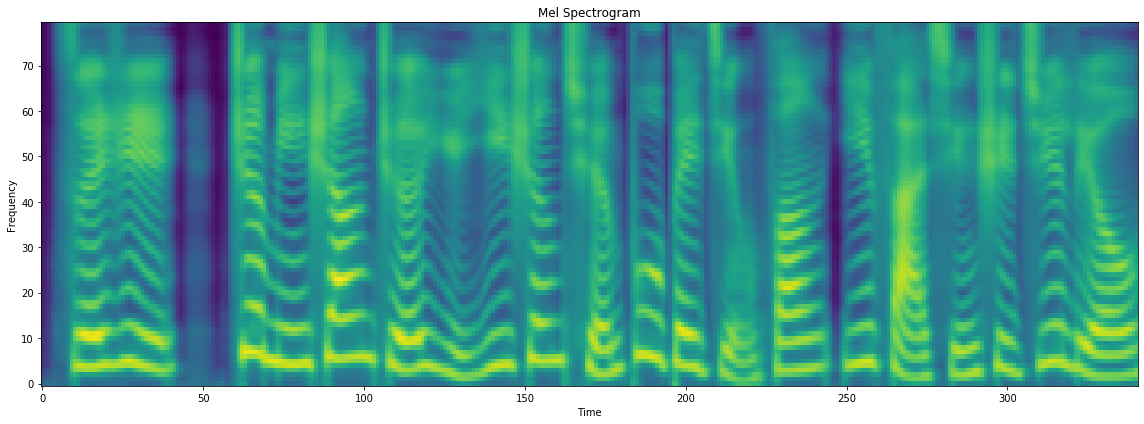

In [6]:
# 绘制 mel 频谱图
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel1.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [7]:
# 声码器推理
wav1 = get_voc_output(voc_predictor=voc_predictor, input=mel1)

In [8]:
# 播放音频
wav_path = 'fs2_fp32_infer.wav'
sf.write(wav_path, wav1, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### int8 fs2 + fp32 pwgan 静态图推理

In [9]:
device = 'cpu'
precision = 'int8'
model_file = 'fastspeech2_csmsc.pdmodel'
params_file = 'fastspeech2_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/fastspeech2/fastspeech2_csmsc_quant'
am_predictor_2 = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

phone_ids =  [261, 231, 175, 116, 179, 262, 44, 154, 126, 177, 19, 262, 42, 241, 72, 177, 56, 174, 245, 37, 186, 37, 49, 151, 127, 69, 19, 179, 72, 69, 4, 260, 126, 177, 116, 151, 239, 153, 141]
phone_ids = np.array(phone_ids)
mel2 = get_am_output(phone_ids=phone_ids, am_predictor=am_predictor_2)

MKLDNN with int8


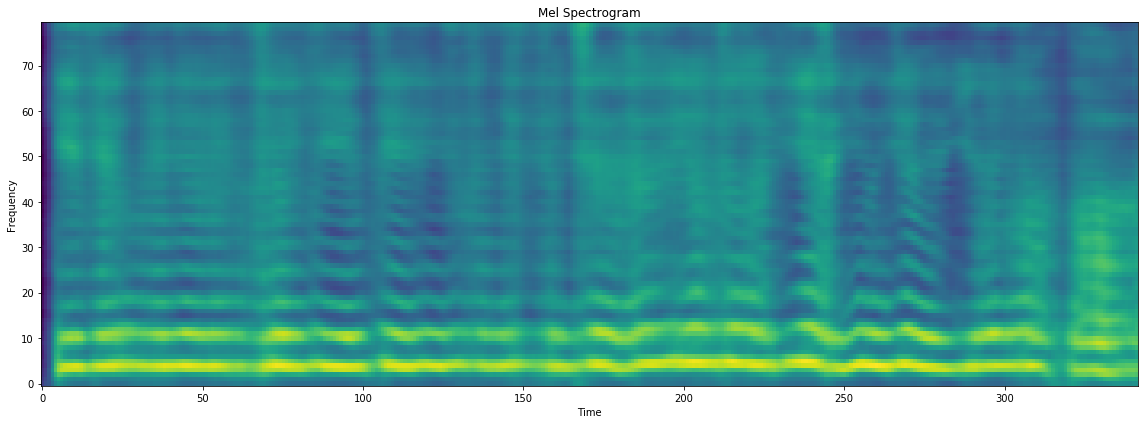

In [10]:
# 绘制 mel 频谱图 -> 看不出内容，低频部分的频谱几乎都是平的，所以也听不出什么内容
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel2.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [11]:
# 声码器推理
wav2 = get_voc_output(voc_predictor=voc_predictor, input=mel2)

In [12]:
# 播放音频
wav_path = 'fs2_int8_infer.wav'
sf.write(wav_path, wav2, samplerate=24000)
dp.Audio(wav_path, rate=24000)

## int8 fs2 exe.run() + fp32 pwgan

In [13]:
paddle.enable_static()
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/fastspeech2/fastspeech2_csmsc_quant/fastspeech2_csmsc'
exe = paddle.static.Executor(paddle.CUDAPlace(0))
[fastspeech2_inference, feed_target_names, fetch_targets] = paddle.static.load_inference_model(model_dir, exe)
# 009901
phone_ids =  [261, 231, 175, 116, 179, 262, 44, 154, 126, 177, 19, 262, 42, 241, 72, 177, 56, 174, 245, 37, 186, 37, 49, 151, 127, 69, 19, 179, 72, 69, 4, 260, 126, 177, 116, 151, 239, 153, 141]
phone_ids = np.array(phone_ids)
mel_runexe = exe.run(fastspeech2_inference, feed={feed_target_names[0]:phone_ids},fetch_list=fetch_targets)

In [14]:
mel_runexe = np.array(mel_runexe)
mel_runexe = mel_runexe[0]

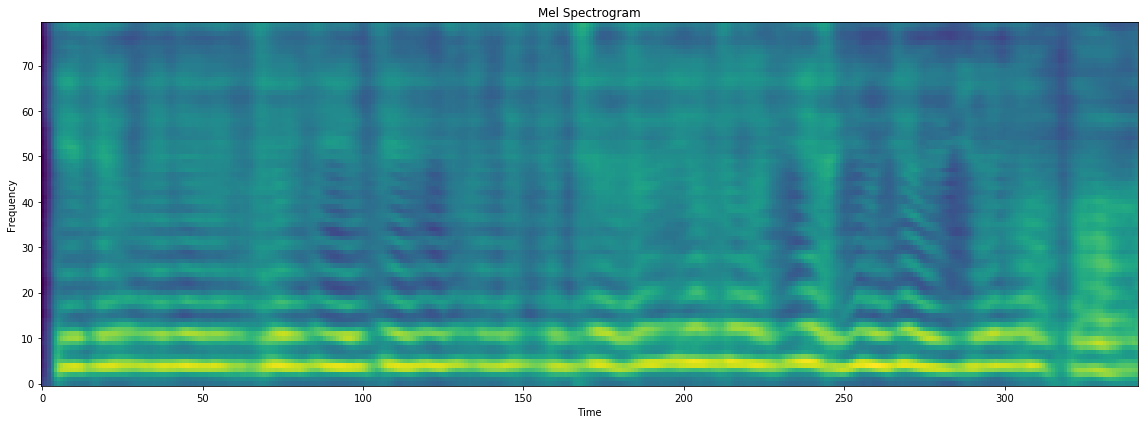

In [15]:
# 绘制 mel 频谱图 -> 发现 run.exe() 的输出不符合预期, 所以是 PaddleSlim 产出模型的问题
# 和静态图推理的结果在 1e-2 上有一些精度差异
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel_runexe.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [16]:
# 声码器推理
wav3 = get_voc_output(voc_predictor=voc_predictor, input=mel_runexe)

In [17]:
# 播放音频
wav_path = 'fs2_int8_runexe.wav'
sf.write(wav_path, wav3, samplerate=24000)
dp.Audio(wav_path, rate=24000)

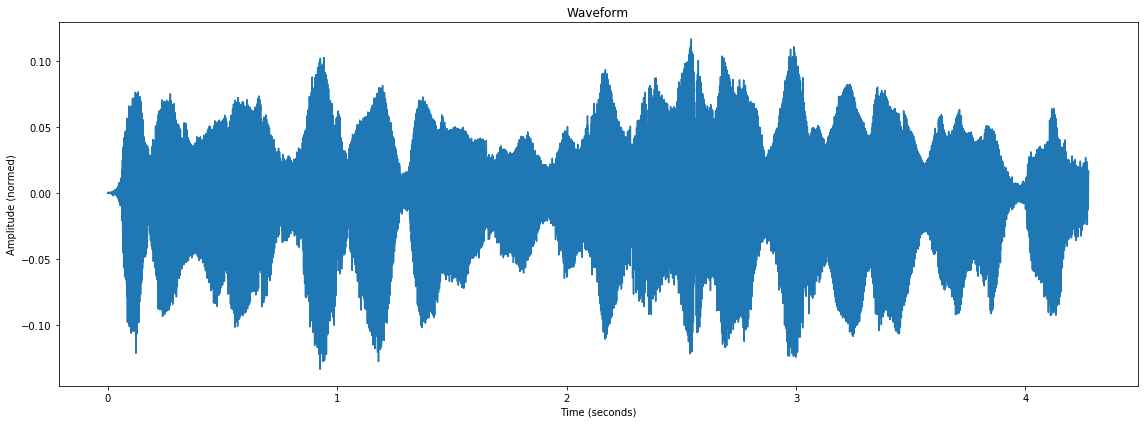

In [18]:
# 绘制波形图
wave_data = wav3.T
time = np.arange(0, wave_data.shape[1]) * (1.0 / 24000)
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(time, wave_data[0])
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (normed)')
plt.tight_layout()

## SpeedySpeech
与 FastSpeech2 类似，可以等 FastSpeech2 选择一个较好的压缩策略后再调整

In [19]:
# new get_am_output for SpeedySpeech
def get_am_output(
        phone_ids,
        tone_ids,
        am_predictor: paddle.nn.Layer):
    am_input_names = am_predictor.get_input_names()
    phones = np.array(phone_ids)
    phones_handle = am_predictor.get_input_handle(am_input_names[0])
    phones_handle.reshape(phones.shape)
    phones_handle.copy_from_cpu(phones)

    tones = np.array(tone_ids)
    tones_handle = am_predictor.get_input_handle(am_input_names[1])
    tones_handle.reshape(tones.shape)
    tones_handle.copy_from_cpu(tones)

    am_predictor.run()
    am_output_names = am_predictor.get_output_names()
    am_output_handle = am_predictor.get_output_handle(am_output_names[0])
    am_output_data = am_output_handle.copy_to_cpu()
    return am_output_data

### fp32 SpeedySpeech + fp32 pwgan  静态图推理

In [20]:
model_file = 'speedyspeech_csmsc.pdmodel'
params_file = 'speedyspeech_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/speedyspeech/speedyspeech_csmsc_static_1.4.0'

device = 'cpu'
precision = 'fp32'
am_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )

# 昨日，这名伤者与医生全部被警方依法刑事拘留
phone_ids = [87, 78, 58, 34, 62, 88, 15, 49, 38, 60, 6, 88, 15, 81, 24, 60, 18, 57, 82, 11, 66, 11, 16, 46, 38, 21, 6, 62, 24, 21, 2, 86, 38, 60, 34, 46, 81, 48, 43]
tone_ids = [0, 2, 0, 4, 0, 0, 4, 0, 2, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 0, 4, 0, 4, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 1, 0, 2]
phone_ids = np.array(phone_ids)
tone_ids = np.array(tone_ids)
mel1 = get_am_output(phone_ids=phone_ids, tone_ids=tone_ids, am_predictor=am_predictor)

MKLDNN with fp32


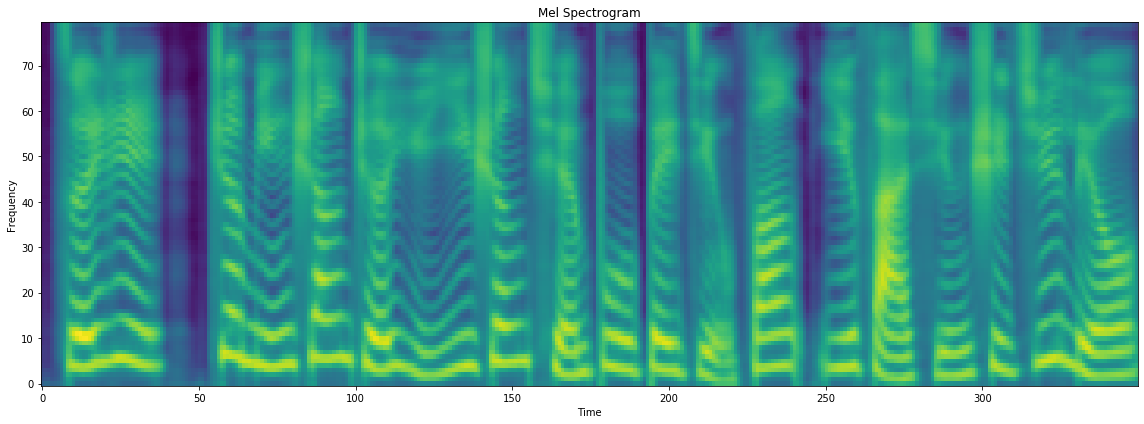

In [21]:
# 绘制 mel 频谱图
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel1.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [22]:
# 声码器推理
wav1 = get_voc_output(voc_predictor=voc_predictor, input=mel1)

In [23]:
# 播放音频
wav_path = 'ss_fp32_infer.wav'
sf.write(wav_path, wav1, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### fp32 SpeedySpeech + fp32 pwgan  静态图推理

In [24]:
device = 'cpu'
precision = 'int8'
model_file = 'speedyspeech_csmsc.pdmodel'
params_file = 'speedyspeech_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/speedyspeech/speedyspeech_csmsc_quant'
am_predictor_2 = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )
# 昨日，这名伤者与医生全部被警方依法刑事拘留
phone_ids = [87, 78, 58, 34, 62, 88, 15, 49, 38, 60, 6, 88, 15, 81, 24, 60, 18, 57, 82, 11, 66, 11, 16, 46, 38, 21, 6, 62, 24, 21, 2, 86, 38, 60, 34, 46, 81, 48, 43]
tone_ids = [0, 2, 0, 4, 0, 0, 4, 0, 2, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 0, 4, 0, 4, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 1, 0, 2]
phone_ids = np.array(phone_ids)
tone_ids = np.array(tone_ids)
mel2 = get_am_output(phone_ids=phone_ids, tone_ids=tone_ids, am_predictor=am_predictor_2)

MKLDNN with int8


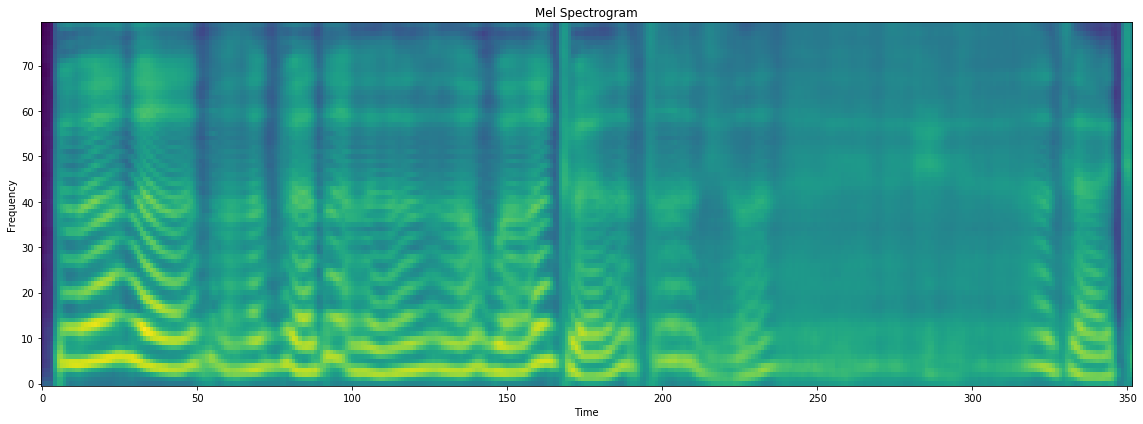

In [25]:
# 绘制 mel 频谱图
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel2.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [26]:
# 声码器推理
wav2 = get_voc_output(voc_predictor=voc_predictor, input=mel2)

In [27]:
# 播放音频
wav_path = 'ss_int8_infer.wav'
sf.write(wav_path, wav2, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### int8 ss exe.run() + fp32 pwgan

In [28]:
paddle.enable_static()
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/speedyspeech/speedyspeech_csmsc_quant/speedyspeech_csmsc'
exe = paddle.static.Executor(paddle.CUDAPlace(0))
[speedyspeech_inference, feed_target_names, fetch_targets] = paddle.static.load_inference_model(model_dir, exe)
# 009901
phone_ids = [87, 78, 58, 34, 62, 88, 15, 49, 38, 60, 6, 88, 15, 81, 24, 60, 18, 57, 82, 11, 66, 11, 16, 46, 38, 21, 6, 62, 24, 21, 2, 86, 38, 60, 34, 46, 81, 48, 43]
tone_ids = [0, 2, 0, 4, 0, 0, 4, 0, 2, 0, 1, 0, 2, 3, 1, 0, 1, 0, 2, 0, 4, 0, 4, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 1, 0, 2]
phone_ids = np.array(phone_ids)
tone_ids = np.array(tone_ids)
mel_runexe = exe.run(speedyspeech_inference, feed={feed_target_names[0]:phone_ids, feed_target_names[1]:tone_ids}, fetch_list=fetch_targets)

In [29]:
mel_runexe = np.array(mel_runexe)
mel_runexe = mel_runexe[0]

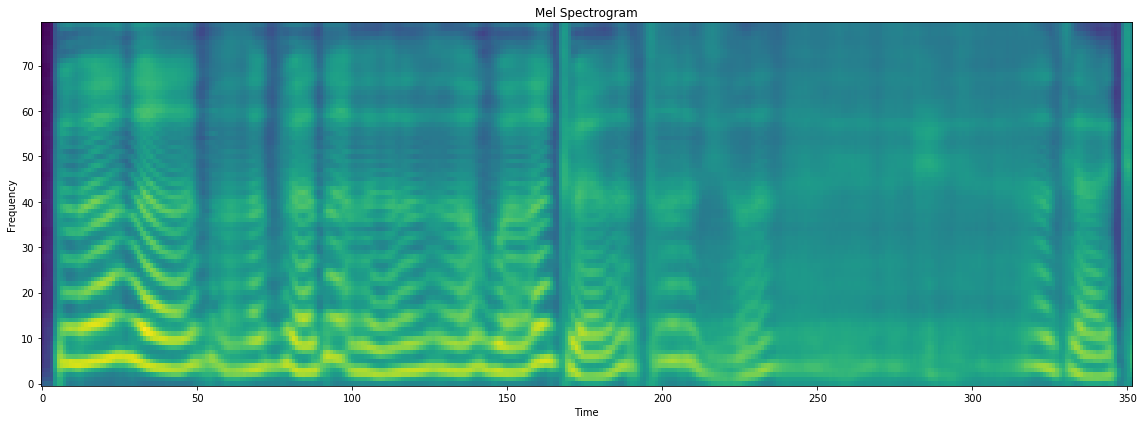

In [30]:
# 绘制 mel 频谱图
fig, ax = plt.subplots(figsize=(16, 6))
im = ax.imshow(mel_runexe.T, aspect='auto',origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

In [31]:
# 声码器推理
wav3 = get_voc_output(voc_predictor=voc_predictor, input=mel_runexe)

In [32]:
# 播放音频
wav_path = 'ss_int8_runexe.wav'
sf.write(wav_path, wav3, samplerate=24000)
dp.Audio(wav_path, rate=24000)

## PWGAN -> 可以用 PaddleInference 推理(速度很慢)，只是压缩较厉害，能听出噪声
由于 PaddleInference 推理 int8 模型很慢，这里用 PaddleInference 推理 fp32 模型，用 run.exe() 推理 int8 模型
如果所有 int8 模型均能跑通 run.exe() 推理，则证明 int8 模型没有问题

In [33]:
# 使用 gt 的 mel 合成 wav
gt_mel_path = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/dump/test/raw/009901_feats.npy'
gt_mel = np.load(gt_mel_path)

### fp32 静态图推理


In [34]:
# 上述的 mel 用 pwgan 静态图推理产生 wav
model_file = 'pwgan_csmsc.pdmodel'
params_file = 'pwgan_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/pwgan_csmsc_static_1.4.0'
device = 'cpu'
precision = 'fp32'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )
wav = get_voc_output(voc_predictor=voc_predictor, input=gt_mel)


MKLDNN with fp32


In [35]:
wav_path = 'pwgan_fp32_infer.wav'
sf.write(wav_path, wav, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### int8 run.exe() 推理 -> ✅


In [36]:
paddle.enable_static()
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/pwgan_csmsc_quant/pwgan_csmsc'
exe = paddle.static.Executor(paddle.CUDAPlace(0))
[pwgan_inference, feed_target_names, fetch_targets] = paddle.static.load_inference_model(model_dir, exe)
# 009901
pwgan_int8_runexe = exe.run(pwgan_inference, feed={feed_target_names[0]:gt_mel},fetch_list=fetch_targets)

In [37]:
pwgan_int8_runexe = np.array(pwgan_int8_runexe)[0]

In [38]:
wav_path = 'pwgan_int8_runexe.wav'
sf.write(wav_path, pwgan_int8_runexe, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### 之前跑的 int8 PaddleInference 推理结果


In [39]:
pwgan_int8_infer = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/pwgan_csmsc_output/int8_norm/009901.wav'
dp.Audio(pwgan_int8_infer, rate=24000)

## MB_MelGAN -> PaddleInference 无法推理，用 run.exe() 验证下量化模型是否有问题

### fp32 静态图推理

In [40]:
# 上述的 mel 用 mb_melgan 静态图推理产生 wav
model_file = 'mb_melgan_csmsc.pdmodel'
params_file = 'mb_melgan_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/mb_melgan_csmsc_static_1.4.0'
device = 'cpu'
precision = 'fp32'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )
wav = get_voc_output(voc_predictor=voc_predictor, input=gt_mel)

MKLDNN with fp32


In [41]:
wav_path = 'mb_melgan_fp32_infer.wav'
sf.write(wav_path, wav, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### PaddleInference int8 推理报错 ->❎

In [42]:
model_file = 'mb_melgan_csmsc.pdmodel'
params_file = 'mb_melgan_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/mb_melgan_csmsc_quant'
precision = 'int8'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )
wav = get_voc_output(voc_predictor=voc_predictor, input=gt_mel)

MKLDNN with int8


RuntimeError: (PreconditionNotMet) The number of first scale values must be the same with quant_axis dimension value of Input(X) when the `scale` has only one element, but 384 != 192 here.
  [Hint: Expected scale->numel() == in_tmp.dims()[quant_axis], but received scale->numel():384 != in_tmp.dims()[quant_axis]:192.] (at /paddle/paddle/fluid/operators/quantize_linear_op.h:172)
  [operator < dequantize_linear > error]

### int8 run.exe() 推理 -> 报错，而且和 PaddleInference 报错一样 ->❎

In [43]:
paddle.enable_static()
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/mb_melgan_csmsc_quant/mb_melgan_csmsc'
exe = paddle.static.Executor(paddle.CUDAPlace(0))
[mb_melgan_inference, feed_target_names, fetch_targets] = paddle.static.load_inference_model(model_dir, exe)
# 009901
mb_melgan_int8_runexe = exe.run(mb_melgan_inference, feed={feed_target_names[0]:gt_mel},fetch_list=fetch_targets)

RuntimeError: (PreconditionNotMet) The number of first scale values must be the same with quant_axis dimension value of Input(X) when the `scale` has only one element, but 384 != 192 here.
  [Hint: Expected scale->numel() == in_tmp.dims()[quant_axis], but received scale->numel():384 != in_tmp.dims()[quant_axis]:192.] (at /paddle/paddle/fluid/operators/quantize_linear_op.h:172)
  [operator < dequantize_linear > error]

## HiFiGAN -> PaddleInference 无法推理，用 run.exe() 验证下量化模型是否有问题

### fp32 静态图推理

In [44]:
model_file = 'hifigan_csmsc.pdmodel'
params_file = 'hifigan_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/hifigan_csmsc_static_1.4.0'

device = 'cpu'
precision = 'fp32'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )
wav = get_voc_output(voc_predictor=voc_predictor, input=gt_mel)

MKLDNN with fp32


In [45]:
wav_path = 'hifigan_fp32_infer.wav'
sf.write(wav_path, wav, samplerate=24000)
dp.Audio(wav_path, rate=24000)

### PaddleInference int8 推理报错 ->❎

In [46]:
model_file = 'hifigan_csmsc.pdmodel'
params_file = 'hifigan_csmsc.pdiparams'
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/hifigan_csmsc_quant'
precision = 'int8'
voc_predictor = get_predictor(
        model_dir=model_dir,
        model_file=model_file,
        params_file=params_file,
        device=device,
        use_mkldnn=True,
        precision=precision
    )
wav = get_voc_output(voc_predictor=voc_predictor, input=gt_mel)

MKLDNN with int8


RuntimeError: (PreconditionNotMet) The number of first scale values must be the same with quant_axis dimension value of Input(X) when the `scale` has only one element, but 512 != 256 here.
  [Hint: Expected scale->numel() == in_tmp.dims()[quant_axis], but received scale->numel():512 != in_tmp.dims()[quant_axis]:256.] (at /paddle/paddle/fluid/operators/quantize_linear_op.h:172)
  [operator < dequantize_linear > error]

### int8 run.exe() 推理 -> 报错，而且和 PaddleInference 报错一样 ->❎

In [47]:
paddle.enable_static()
model_dir = '/home/yuantian01/paddle_work/slim_infer_unittest/gan_vocoders/hifigan_csmsc_quant/hifigan_csmsc'
exe = paddle.static.Executor(paddle.CUDAPlace(0))
[mb_melgan_inference, feed_target_names, fetch_targets] = paddle.static.load_inference_model(model_dir, exe)
# 009901
mb_melgan_int8_runexe = exe.run(mb_melgan_inference, feed={feed_target_names[0]:gt_mel},fetch_list=fetch_targets)

RuntimeError: (PreconditionNotMet) The number of first scale values must be the same with quant_axis dimension value of Input(X) when the `scale` has only one element, but 512 != 256 here.
  [Hint: Expected scale->numel() == in_tmp.dims()[quant_axis], but received scale->numel():512 != in_tmp.dims()[quant_axis]:256.] (at /paddle/paddle/fluid/operators/quantize_linear_op.h:172)
  [operator < dequantize_linear > error]